In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

In [2]:
df = pd.read_csv("data/df_encoding.csv", index_col = 0)
df.head()

,age,sex,bmi,children,smoker,region,charges,charges_Sklearn,age_robust,bmi_robust,children_robust,smoker_map,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,southwest,16884.92400,0.472641,-0.80,-0.228803,-0.5,1,1,0,0,0,0,1
1,18,male,33.770,1,no,southeast,1725.55230,0.018101,-0.84,0.503117,0.0,0,0,1,0,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,0.099775,-0.44,0.407107,1.0,0,0,1,0,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,0.625547,-0.24,-0.876559,-0.5,0,0,1,0,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,0.082306,-0.28,-0.106608,-0.5,0,0,1,0,1,0,0


## Decision Tree con los datos orginales:

Primero vamos a probar a hacerlo con los datos orginales más el encoding:


In [3]:
df2 = df.drop(['charges_Sklearn', 'age_robust', 'bmi_robust', 'children_robust', 'smoker', 'region','sex'],axis=1)

In [4]:
df2.columns

Index(['age', 'bmi', 'children', 'charges', 'smoker_map', 'sex_female',
       'sex_male', 'region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest'],
      dtype='object')

In [5]:
X = df2.drop("charges", axis = 1)  #Separamos nuestros datos
y = df2["charges"]

In [6]:
# Dividimos nuestros datos en train y test 

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [7]:
# creamos el objeto del modelo
arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

In [8]:
#Vemos las predicciones

y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [9]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [10]:
dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1 #Comprobamos los resultados

,MAE,MSE,RMSE,R2,set,modelo
0,3076.706377,4.054665e+07,6367.625476,0.246239,test,Decission Tree I
1,33.029845,2.727937e+05,522.296522,0.994749,train,Decission Tree I


Vemos que hay overfitting porque salen mejores resultados en train que en test, decidimos cambiar los parámetros ajustando la profundidad y las variables.

In [11]:
max_features = np.sqrt(len(x_train.columns))
max_features #Nuestra profundiad máxima será de  4. PREGUNTAMOS.

3.1622776601683795

In [12]:
print(arbol.tree_.max_depth)

19


In [13]:
df2.shape #Miramos cuantos datos  tenemos para comprobar que son correctos los parámetros.

(1198, 11)

In [14]:
param = {"max_depth": [4,6,9], # Reducimos la profundidad del modelo, la nuestra anterior era de 19. 
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 


Ajustamos a los parámetros:

In [15]:
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [16]:
gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 6, 9], 'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [17]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=9, max_features=4, min_samples_leaf=10,
                      min_samples_split=10)

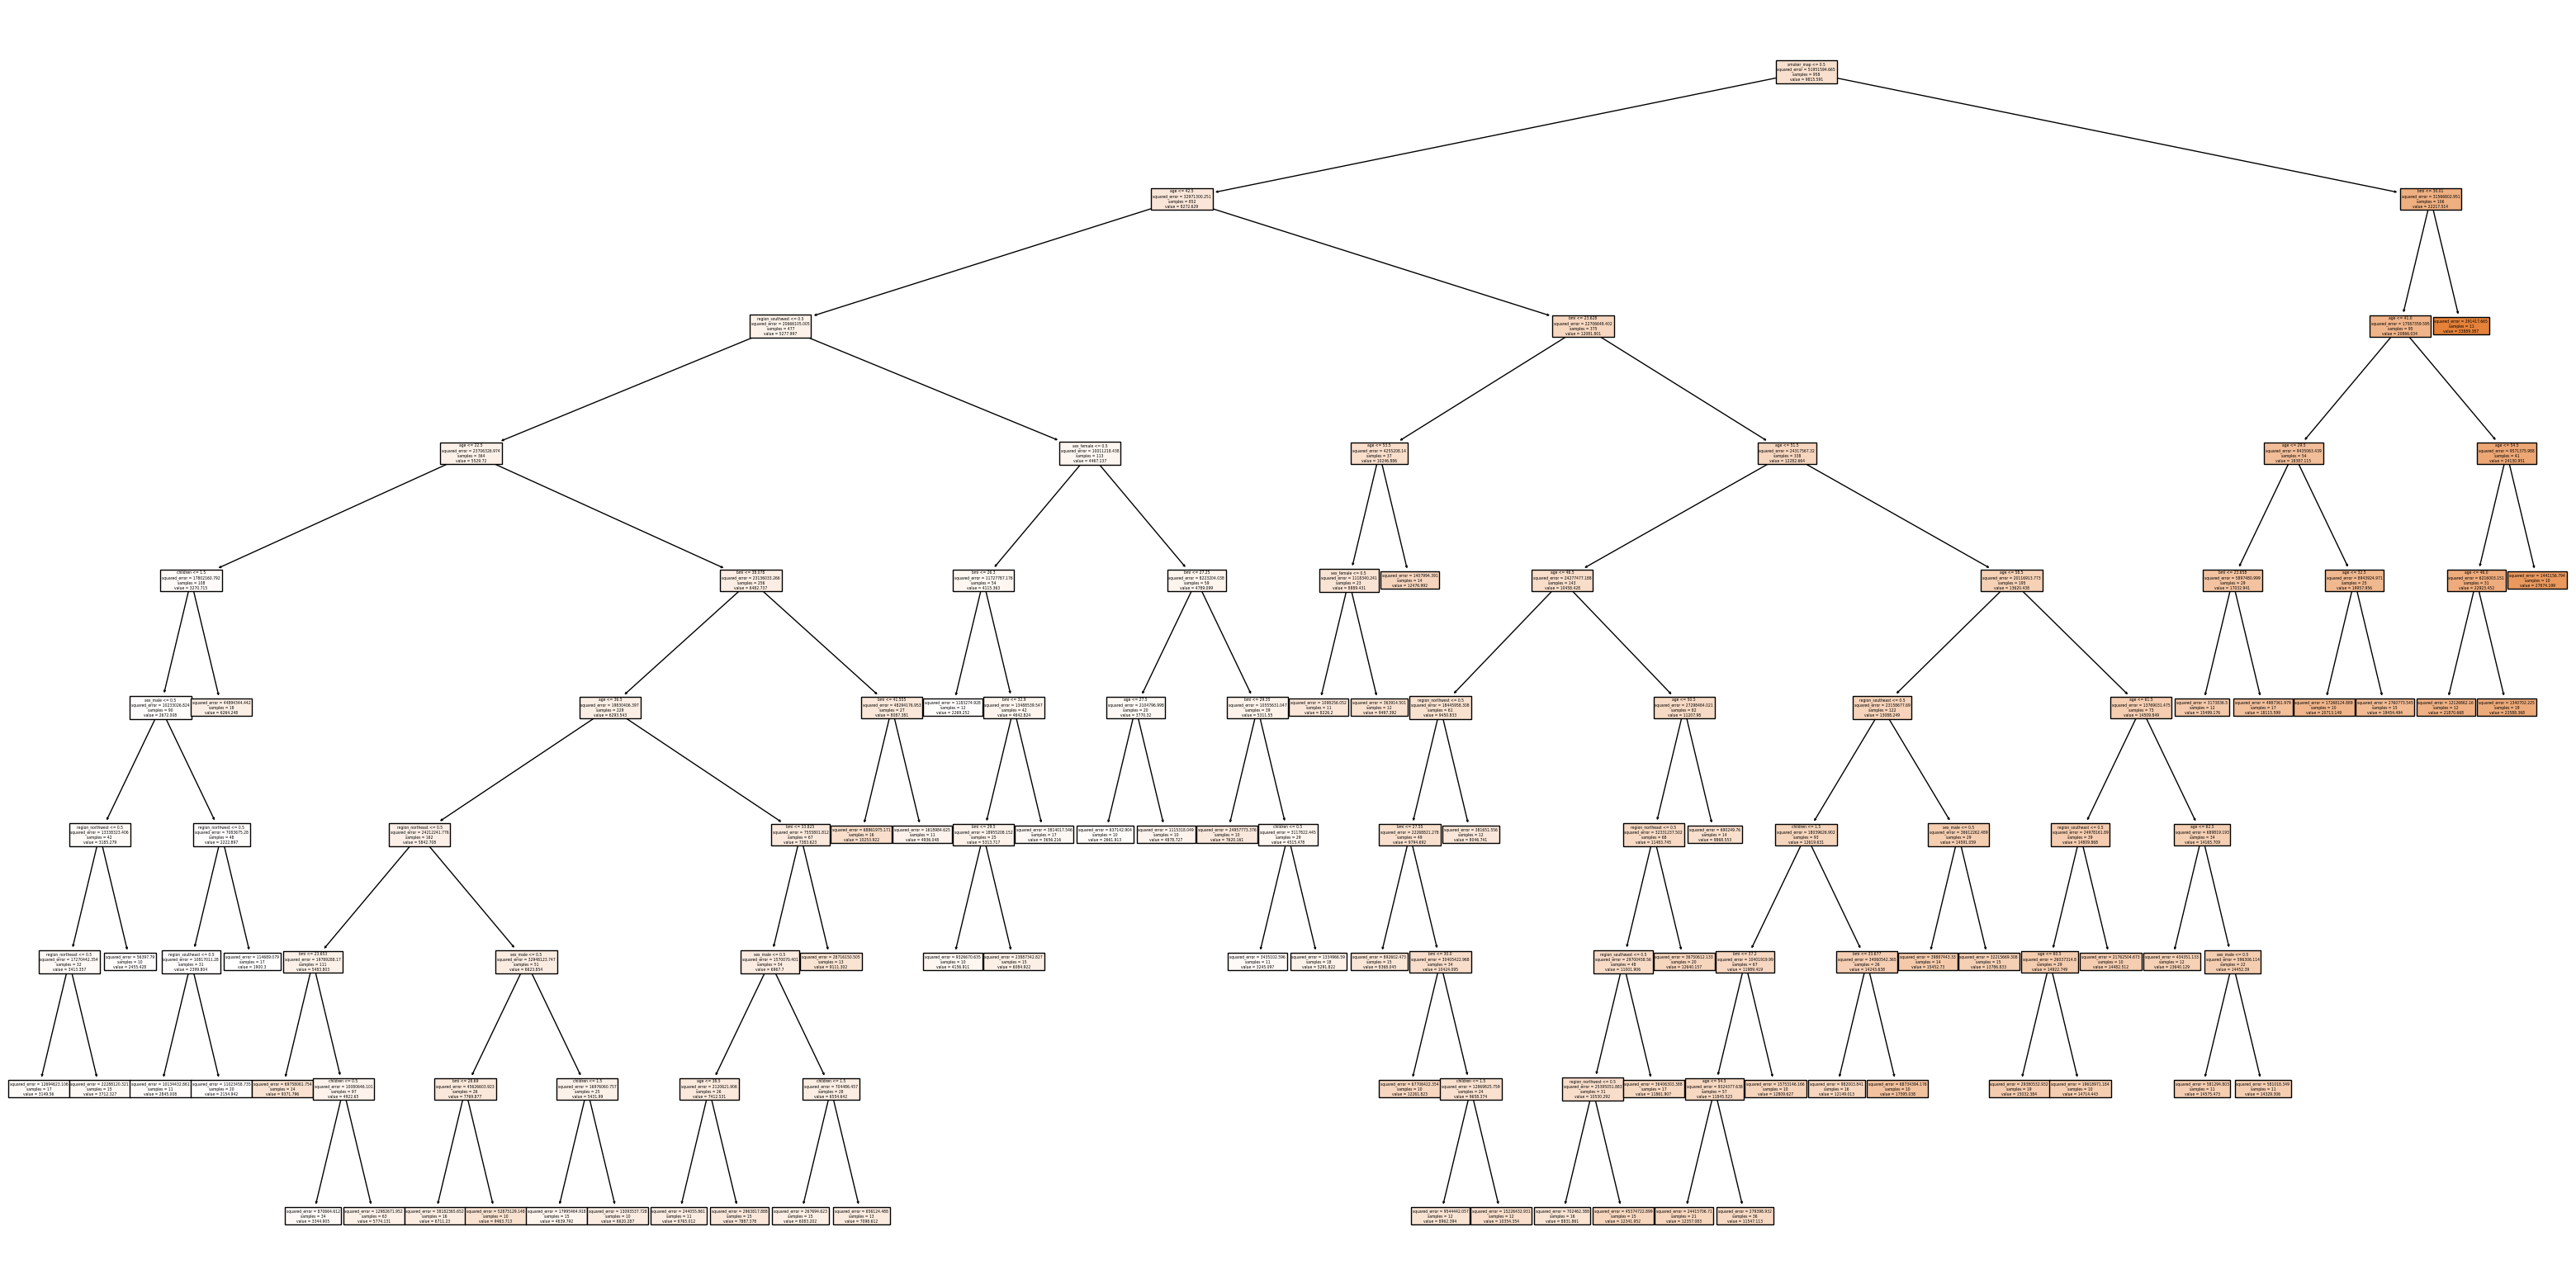

In [18]:
fig = plt.figure(figsize=(40, 20)) #Miramos como nos ha quedado el árbol
tree.plot_tree(mejor_modelo, feature_names=x_train.columns, filled=True);

Sacamos los resultados:

In [19]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [20]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2


,MAE,MSE,RMSE,R2,set,modelo
0,2656.670334,2.352545e+07,4850.304131,0.562663,test,Decision tree II
1,2223.741528,1.512946e+07,3889.660418,0.708778,train,Decision tree II


Parece que ahora está mejor, no parece que tenga under/overfitting, pero no explica mucho de nuestros datos y el RMSE es muy, muy alto.

In [21]:
df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results #Lo miramos con los resultados anteriores

,MAE,MSE,RMSE,R2,set,modelo
0,3076.706377,4.054665e+07,6367.625476,0.246239,test,Decission Tree I
1,33.029845,2.727937e+05,522.296522,0.994749,train,Decission Tree I
0,2656.670334,2.352545e+07,4850.304131,0.562663,test,Decision tree II
1,2223.741528,1.512946e+07,3889.660418,0.708778,train,Decision tree II


Vamos a ver qué variables predictoras funcionan mejor:

In [22]:
# vamos a crearnos un dataframe 
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores


Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
3,smoker_map,0.519679
0,age,0.366750
1,bmi,0.083499
2,children,0.013891
7,region_northwest,0.003815
5,sex_male,0.003423
9,region_southwest,0.003312
8,region_southeast,0.002572
6,region_northeast,0.002433
4,sex_female,0.000626


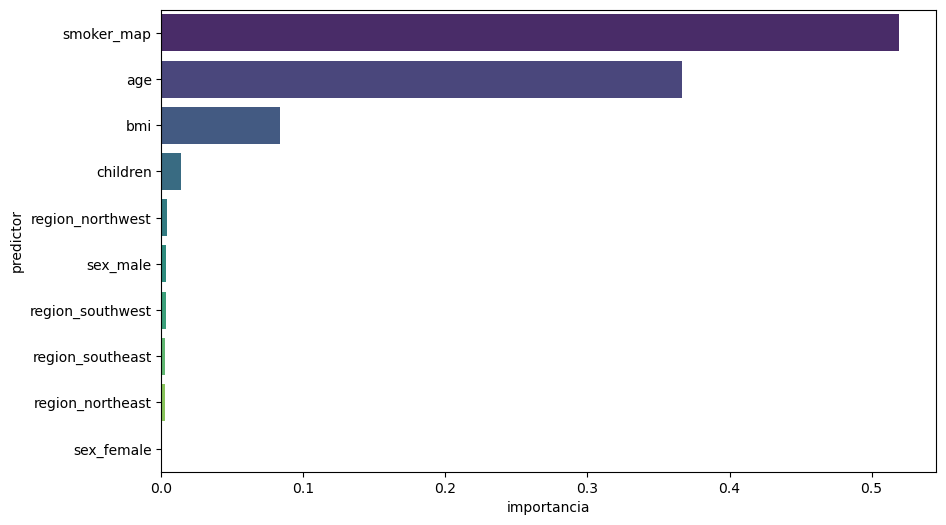

In [23]:
plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()

La variable 'smoker_map' es la que más influye. POr lo que ser o no ser fumador es determinante a la hora de predecir el precio del seguro médico.

## Vamos a probar con los datos resultantes de la normalización y la estandarización.

In [24]:
df3 = pd.read_csv("data/df_encoding.csv", index_col = 0)
df3.head()

,age,sex,bmi,children,smoker,region,charges,charges_Sklearn,age_robust,bmi_robust,children_robust,smoker_map,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,southwest,16884.92400,0.472641,-0.80,-0.228803,-0.5,1,1,0,0,0,0,1
1,18,male,33.770,1,no,southeast,1725.55230,0.018101,-0.84,0.503117,0.0,0,0,1,0,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,0.099775,-0.44,0.407107,1.0,0,0,1,0,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,0.625547,-0.24,-0.876559,-0.5,0,0,1,0,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,0.082306,-0.28,-0.106608,-0.5,0,0,1,0,1,0,0


In [25]:
df3.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'charges_Sklearn', 'age_robust', 'bmi_robust', 'children_robust',
       'smoker_map', 'sex_female', 'sex_male', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')

In [26]:
df3 = df3.drop(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], axis=1)

In [27]:

X1 = df3.drop("charges_Sklearn", axis = 1)
y1 = df3["charges_Sklearn"]

In [28]:
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

In [29]:
# creamos el objeto del modelo
arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo
arbol.fit(x1_train, y1_train)

DecisionTreeRegressor(random_state=0)

In [30]:
y1_pred_test_dt = arbol.predict(x1_test)
y1_pred_train_dt = arbol.predict(x1_train)

In [31]:
def metricas(y1_test, y1_train, y1_test_pred, y1_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y1_test, y1_test_pred), mean_absolute_error(y1_train, y1_train_pred)],
                'MSE': [mean_squared_error(y1_test, y1_test_pred), mean_squared_error(y1_train, y1_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y1_test, y1_test_pred)), np.sqrt(mean_squared_error(y1_train, y1_train_pred))],
                'R2':  [r2_score(y1_test, y1_test_pred), r2_score(y1_train, y1_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [32]:
dt_results3 = metricas(y1_test, y1_train, y1_pred_test_dt, y1_pred_train_dt, "Decission Tree I")
dt_results3

,MAE,MSE,RMSE,R2,set,modelo
0,0.088744,0.034387,0.185438,0.288959,test,Decission Tree I
1,0.000990,0.000245,0.015661,0.994749,train,Decission Tree I


Tenemos overfitting, vamos a cambiar los parámetros.

In [33]:
max_features2 = np.sqrt(len(x1_train.columns))
max_features2

3.1622776601683795

In [34]:
print(arbol.tree_.max_depth)

19


In [35]:
param = {"max_depth": [4,6,9], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 


In [36]:
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [37]:
gs.fit(x1_train, y1_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 6, 9], 'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [38]:
mejor_modelo1 = gs.best_estimator_
mejor_modelo1

DecisionTreeRegressor(max_depth=6, max_features=4, min_samples_leaf=10,
                      min_samples_split=10)

In [39]:
y1_pred_test_dt2 = mejor_modelo1.predict(x1_test)
y1_pred_train_dt2 = mejor_modelo1.predict(x1_train)

In [40]:
dt_results3 = metricas(y1_test, y1_train, y1_pred_test_dt2, y1_pred_train_dt2, "Decision tree II")
dt_results3


,MAE,MSE,RMSE,R2,set,modelo
0,0.094268,0.025826,0.160706,0.465978,test,Decision tree II
1,0.076096,0.016621,0.128923,0.644138,train,Decision tree II
